# Extraction of features

In this script, we will look into movements within trials and extract some features that could be informative about effort.

The possible features of interest:
- duration of movement - DONE 
- peaks and their amplitude - in movement, speed, acceleration
- number of peaks, ie., number of submovements - DONE
- intermittency - DONE
- gesture space


# Folder setting

In [238]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

curfolder = os.getcwd()
mergedfolder = curfolder + "\\TS_merged\\"
filestotrack = glob.glob(mergedfolder + "merged_anno*.csv")

# for now we can keep only 0_2 in the list
filestotrack = [x for x in filestotrack if "0_2_" in x]

In [239]:
# function to detect outliers based on Tukey's fences
def detect_outliers(df, colname):
    Q1 = df[colname].quantile(0.25)
    Q3 = df[colname].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[colname] > (Q1 - 1.5 * IQR)) & (df[colname] < (Q3 + 1.5 * IQR))]

# Preparations

## COP

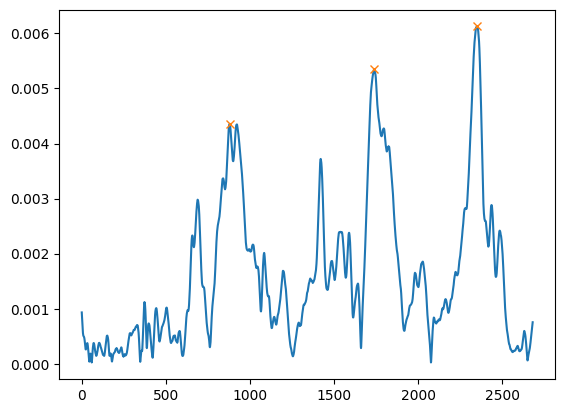

In [105]:
sample = filestotrack[60]
df = pd.read_csv(sample)


# find peaks with height of mean + 2*std
peaks, _ = find_peaks(df["COPc"], height=df["COPc"].mean()+df["COPc"].std(), distance=400)

# find the values of the peaks
peaks_values = df.loc[peaks, "COPc"]

x = df['COPc']
plt.plot(x)
plt.plot(peaks, x[peaks], 'x')
plt.show()

## env peaks

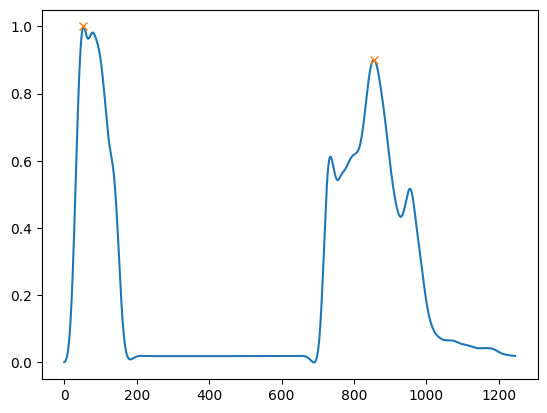

In [111]:
sample = filestotrack[100]
df = pd.read_csv(sample)

# get only sudf in which vocalization is to sounding
subdf = df[df["vocalization"] == "sounding"]
# reset index
subdf = subdf.reset_index(drop=True)

# find peaks with height of mean + 2*std
peaks, _ = find_peaks(subdf["envelope"], height=df["envelope"].mean()+df["envelope"].std(), distance=200)

# find the values of the peaks
peaks_values = subdf.loc[peaks, "envelope"]

x = subdf['envelope']
plt.plot(x)
plt.plot(peaks, x[peaks], 'x')
plt.show()

## f0 peaks

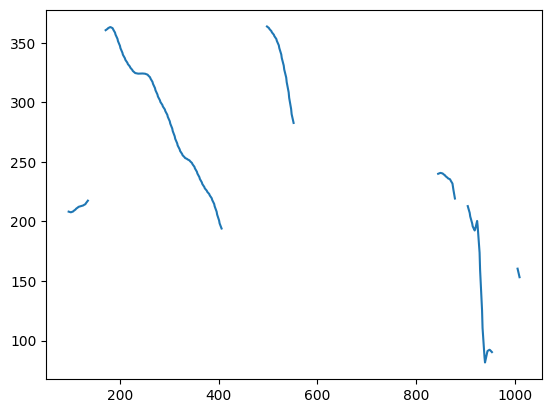

In [295]:
sample = filestotrack[20]
df = pd.read_csv(sample)

# get only sudf in which vocalization is to sounding
subdf = df[df["vocalization"] == "sounding"]
# reset index
subdf = subdf.reset_index(drop=True)

# find peaks with height of mean + 2*std
peaks, _ = find_peaks(subdf["f0"], height=df["f0"].mean(), distance=200, threshold=0.01)

# find the values of the peaks
peaks_values = subdf.loc[peaks, "f0"]

x = subdf['f0']
plt.plot(x)
plt.plot(peaks, x[peaks], 'x')
plt.show()

## movement peaks

In [ ]:
sample = filestotrack[50]
df = pd.read_csv(sample)

#  only where arms are set to movement
subdf = df[df["arms"] == "movement"]
# reset index
subdf = subdf.reset_index(drop=True)

# arms columns
arms_col = ['Wrist', 'wrist', 'Elbow', 'elbow', 'Shoulder', 'shoulder', 'arm']
# get columns in subdf that contains arms_col in their name
arms_col = [col for col in subdf.columns if any(arm in col for arm in arms_col)]
# get rid of columns that do not contain speed, acc, or moment
arms_col = [col for col in arms_col if any(x in col for x in ['speed', 'acc', 'moment'])]
print(arms_col)
len(arms_col)
# find peaks with height of mean + std
for col in arms_col:
    print(col)
    peaks, _ = find_peaks(subdf[col], height=df[col].mean()+df[col].std(), distance=200)
    print(peaks)
    # find the values of the peaks
    peaks_values = subdf.loc[peaks, col]
    # find times
    peaks_times = subdf.loc[peaks, "time"]

    x = subdf[col]
    plt.plot(x)
    plt.plot(peaks, x[peaks], 'x')
    plt.show()



## submovements

In [124]:
sample = filestotrack[5]
df = pd.read_csv(sample)

#  only where arms are set to movement
subdf = df[df["arms"] == "movement"]
# reset index
subdf = subdf.reset_index(drop=True)

submovcols = [col for col in subdf.columns if "Wrist" in col and 'speed' in col]

for col in submovcols:
    print(col)
    peaks, _ = find_peaks(subdf[col], height=df[col].mean(), distance=150)
    print(peaks)
    # number of peaks
    submov = len(peaks)
    print(submov)

    break

RWrist_speed
[ 67 309 500 809]
4


## number of articulators in move

In [192]:
sample = filestotrack[5]
df = pd.read_csv(sample)

#  only where arms are set to movement
subdf = df[df["movement_in_trial"] == "movement"]
# reset index
subdf = subdf.reset_index(drop=True)

movcols = ['upper_body', 'arms', 'lower_body', 'head_mov']

for trialID in subdf["TrialID"].unique():
    print(trialID)
    # check which movcols have at least some movement in
    submovcols = [col for col in movcols if subdf[subdf["TrialID"] == trialID][col].values[0] == "movement"]
    print(submovcols)
    numofArt = len(submovcols)
    print(numofArt)


0_2_3_p0
['arms']
1


## intermittency

In [242]:
## function (adapted from Wim's paper)

def get_intermittency(df, jerk_values, speed_values):
    """Calculate the dimensionless smoothness measure using precomputed smoothed jerk and speed."""
    smoothed_jerk = jerk_values
    speed = speed_values
    
    if not np.all(speed == 0):
        integrated_squared_jerk = np.sum(smoothed_jerk ** 2)
        max_squared_speed = np.max(speed ** 2)
        D3 = len(speed) ** 3
        jerk_dimensionless = integrated_squared_jerk * (D3 / max_squared_speed)
        smoothness = jerk_dimensionless
    else:
        smoothness = np.nan

    return smoothness

In [249]:
df

,time,left_back,right_forward,right_back,left_forward,COPXc,COPYc,COPc,TrialID,FileInfo,...,elbow_flex_l_acc,pro_sup_l_acc,wrist_flex_l_acc,wrist_dev_l_acc,vocalization,upper_body,arms,lower_body,head_mov,movement_in_trial
0,0.0,1.279352,0.702868,1.533108,1.356779,0.000131,-0.000394,0.000415,0_2_3_p0,p0_vrouw_combinatie_c1,...,-0.038148,-5.467848e-16,0.0,0.0,silent,nomovement,movement,nomovement,nomovement,movement
1,2.0,1.279426,0.702655,1.533071,1.356392,-0.000049,-0.000403,0.000406,0_2_3_p0,p0_vrouw_combinatie_c1,...,-0.038069,-5.455072e-16,0.0,0.0,silent,nomovement,movement,nomovement,nomovement,movement
2,4.0,1.279634,0.702495,1.533086,1.356187,-0.000213,-0.000415,0.000467,0_2_3_p0,p0_vrouw_combinatie_c1,...,-0.037990,-5.442296e-16,0.0,0.0,silent,nomovement,movement,nomovement,nomovement,movement
3,6.0,1.279953,0.702374,1.533144,1.356136,-0.000362,-0.000431,0.000563,0_2_3_p0,p0_vrouw_combinatie_c1,...,-0.037911,-5.429519e-16,0.0,0.0,silent,nomovement,movement,nomovement,nomovement,movement
4,8.0,1.280364,0.702278,1.533233,1.356210,-0.000496,-0.000448,0.000668,0_2_3_p0,p0_vrouw_combinatie_c1,...,-0.037832,-5.416743e-16,0.0,0.0,silent,nomovement,movement,nomovement,nomovement,movement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,2534.0,1.206110,0.727578,1.565515,1.315883,-0.000025,-0.000861,0.000862,0_2_3_p0,p0_vrouw_combinatie_c1,...,-0.289952,-2.140087e-15,0.0,0.0,silent,nomovement,nomovement,nomovement,nomovement,nomovement
1268,2536.0,1.206485,0.727430,1.565809,1.315702,-0.000050,-0.000982,0.000983,0_2_3_p0,p0_vrouw_combinatie_c1,...,-0.293133,-2.085105e-15,0.0,0.0,silent,nomovement,nomovement,nomovement,nomovement,nomovement
1269,2538.0,1.206925,0.727260,1.566135,1.315495,-0.000078,-0.001135,0.001138,0_2_3_p0,p0_vrouw_combinatie_c1,...,-0.296315,-2.030122e-15,0.0,0.0,silent,nomovement,nomovement,nomovement,nomovement,nomovement
1270,2540.0,1.207446,0.727066,1.566500,1.315256,-0.000109,-0.001324,0.001328,0_2_3_p0,p0_vrouw_combinatie_c1,...,-0.299496,-1.975140e-15,0.0,0.0,silent,nomovement,nomovement,nomovement,nomovement,nomovement


In [252]:
sample = filestotrack[5]
df = pd.read_csv(sample)

#  only where arms are set to movement
subdf = df[df["arms"] == "movement"]
# reset index
subdf = subdf.reset_index(drop=True)

# arms columns
arms_col = ['RWrist', 'RElbow', 'RShoulder', 'LWrist', 'LElbow', 'LShoulder']

# get intermittency for each arm_col

for col in arms_col:
    # get the speed column
    speed_col = col + "_speed"
    speed = df[speed_col].values
    # get the jerk column
    jerk_col = col + "_jerk"
    jerk = df[jerk_col].values
    # get the intermittency
    smoothness = get_intermittency(subdf, jerk_col, speed_col)
    #print(smoothness)




# Loop to extract features

In [266]:
features_df = pd.DataFrame()

for file in filestotrack:
    print('working on file: ', file)
    df = pd.read_csv(file)
    df["concept"] = df["FileInfo"].apply(lambda x: x.split("_")[1])
    df["modality"] = df["FileInfo"].apply(lambda x: x.split("_")[2])
    df["correction"] = df["FileInfo"].apply(lambda x: x.split("_")[3])
    df.drop(columns=["FileInfo"], inplace=True)

    movcols = ['upper_body', 'arms', 'lower_body', 'head_mov']
    
    subdf = df[df["movement_in_trial"] == "movement"]
    # check if there is any movement in the trial
    if subdf.shape[0] > 0:
        ### duration
        duration_mov = subdf["time"].iloc[-1] - subdf["time"].iloc[0]

        # check which movcols have at least some movement in
        submovcols = [col for col in movcols if subdf[col].values[0] == "movement"]
        numofArt = len(submovcols)

    else:
        duration_mov = 0
        numofArt = 0

    ### peaks in COP
    cop_peaks_ind, _ = find_peaks(df["COPc"], height=df["COPc"].mean(), distance=400)
    cop_peaks_values = df.loc[cop_peaks_ind, "COPc"]
    cop_peaks_values = cop_peaks_values.tolist()
    # get the time of the peaks
    cop_peaks_time = df.loc[cop_peaks_ind, "time"]
    cop_peaks_time = cop_peaks_time.tolist()

    ### peaks in envelope
    # check whether column vocalization exist
    if "vocalization" not in df.columns:
        print("No vocalization column in the dataframe")
    else:
        subdf = df[df["vocalization"] == "sounding"]
        # reset index
        subdf = subdf.reset_index(drop=True)

        if subdf.shape[0] > 0:
            # duration
            duration_voc = subdf["time"].iloc[-1] - subdf["time"].iloc[0]
            # env peaks
            envelope_peaks_ind, _ = find_peaks(subdf["envelope"], height=df["envelope"].mean(), distance=200)
            envelope_peaks_values = df.loc[envelope_peaks_ind, "envelope"]
            envelope_peaks_values = envelope_peaks_values.tolist()
            # get the times
            envelope_peaks_time = subdf.loc[envelope_peaks_ind, "time"]
            envelope_peaks_time = envelope_peaks_time.tolist()
        else:
            duration_voc = 0
            envelope_peaks_values = []
            envelope_peaks_time = []

        # creta a new row with duration, concept, modality and correction
    newrow = pd.DataFrame({"duration_m": [duration_mov], 'numArtic': numofArt, "duration_v": [duration_voc], 'cop_peaks': [cop_peaks_values], 'cop_peaks_t': [cop_peaks_time], 'env_peaks': [envelope_peaks_values], 'env_peaks_t': [envelope_peaks_time], "concept": [df["concept"].iloc[0]], "modality": [df["modality"].iloc[0]], "correction": [df["correction"].iloc[0]], 'TrialID': [df['TrialID'].iloc[0]]})

    ### peaks in arms
    # only for where arms are moving
    subdf = df[df["arms"] == "movement"]
    # reset index
    subdf = subdf.reset_index(drop=True)

    # prepare dictionary to store the values
    armfeatures_dict = {}

    # arms columns
    arms_col = ['Wrist', 'wrist', 'Elbow', 'elbow', 'Shoulder', 'shoulder', 'arm']
    # get columns in subdf that contains arms_col in their name
    arms_col = [col for col in df.columns if any(arm in col for arm in arms_col)]
    # get rid of columns that do not contain speed, acc, or moment
    arms_col = [col for col in arms_col if any(x in col for x in ['speed', 'acc', 'moment'])]

    ## cols for intermittency
    intercols = ['RWrist', 'RElbow', 'RShoulder', 'LWrist', 'LElbow', 'LShoulder']

    if subdf.shape[0] == 0:
        print("No movement in arms")
        # create row with empty lists for each column
        # create list for each column with _peaks
        armpeaks = [col + '_peaks' for col in arms_col]
        armtime = [col + '_t' for col in arms_col]
        for col in armpeaks:
            armfeatures_dict[col] = []
        for col in armtime:
            armfeatures_dict[col] = []
        newrow_arms = pd.DataFrame({key: [value] for key, value in armfeatures_dict.items()})
        arms_submov = 0
        # each intermittency col will get 0
        for col in intercols:
            colname = col + "_inter"
            armfeatures_dict[colname] = 0
        
        # append the number of submovements in wrist
        newrow_arms['submovements'] = arms_submov
    else:
        # find peaks with height of mean + std
        for col in arms_col:
            peaks, _ = find_peaks(df[col], height=df[col].mean(), distance=200)
            # find the values of the peaks
            peaks_values = df.loc[peaks, col]
            peaks_values = peaks_values.tolist()
            # find times
            peaks_times = df.loc[peaks, "time"]
            peaks_times = peaks_times.tolist()
            # prepare col names
            colname_peak = col + '_peaks'
            colname_time = col + '_t'

            # save in dictionary
            armfeatures_dict[colname_peak] = peaks_values
            armfeatures_dict[colname_time] = peaks_times

        # count submovements in wrist
        submovcols = [col for col in subdf.columns if "Wrist" in col and 'speed' in col]
        submovs = []
        for col in submovcols:
            peaks, _ = find_peaks(subdf[col], height=df[col].mean(), distance=150)
            submovs.append(len(peaks))

        arms_submov = sum(submovs)

        ## intermittency
        for col in intercols:
            speed_col = col + "_speed"
            speed = df[speed_col].values
            jerk_col = col + "_jerk"
            jerk = df[jerk_col].values
            # get the intermittency
            colname = col + "_inter"
            intermittency = get_intermittency(subdf, jerk_col, speed_col)
            # log intermittency
            intermittency = np.log(intermittency)
            #print(smoothness)
            armfeatures_dict[colname] = intermittency

        # create a dataframe from the dictionary
        newrow_arms = pd.DataFrame({key: [value] for key, value in armfeatures_dict.items()})
        # append the number of submovements in wrist
        newrow_arms['submovements'] = arms_submov

                
    # concatenate newrow and newrow_arms
    newrow_final = pd.concat([newrow, newrow_arms], axis=1)

    # concatenate
    features_df = pd.concat([features_df, newrow_final], ignore_index=True)

    

working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_111_p1.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_112_p1.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_0_p0.csv
No vocalization column in the dataframe
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_1_p0.csv
No vocalization column in the dataframe
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_2_p0.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_3_p0.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_4_p0.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_5_p0.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_6_p0.csv
working on file:  e:\FLES

In [268]:
# we need to create a concept id to group together corrections of one concept

for row in features_df.iterrows():
    row = row[1]
    features_df.loc[row.name, "concept_id"] = row["concept"] + "_" + row["modality"] + "_" + row["TrialID"].split("_")[-1]


C:\Users\kadava\AppData\Local\Temp\ipykernel_15808\1123116784.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df.loc[row.name, "concept_id"] = row["concept"] + "_" + row["modality"] + "_" + row["TrialID"].split("_")[-1]


In [269]:
# which concept_id has in correction only c0, but not c1 and c2

c0 = features_df[features_df["correction"] == "c0"]["concept_id"].unique()
c1 = features_df[features_df["correction"] == "c1"]["concept_id"].unique()
c2 = features_df[features_df["correction"] == "c2"]["concept_id"].unique()

In [270]:
# which concept_id is only in c0
only_c0 = [x for x in c0 if x not in c1 and x not in c2]
print(only_c0)
c0_c1 = [x for x in c0 if x in c1 and x not in c2]
print(c0_c1)
all_c = [x for x in c0 if x in c1 and x in c2]
print(all_c)

['juichen_combinatie_p0', 'zingen_combinatie_p0', 'ik_combinatie_p0', 'kauwen_combinatie_p0', 'klok_combinatie_p1', 'vis_combinatie_p1', 'ruiken_combinatie_p1', 'wind_combinatie_p1', 'fiets_gebaren_p0', 'vogel_gebaren_p0', 'vuur_gebaren_p0', 'horen_gebaren_p0', 'telefoon_gebaren_p1', 'blazen_gebaren_p1', 'kat_gebaren_p1', 'lachen_gebaren_p1', 'slapen_gebaren_p1', 'vallen_geluiden_p0', 'grommen_geluiden_p1', 'huilen_geluiden_p1']
['ziek_geluiden_p1', 'vliegtuig_gebaren_p0', 'goed_gebaren_p0', 'geven_gebaren_p1']
['vrouw_combinatie_p0', 'verbranden_combinatie_p0', 'vliegen_combinatie_p0', 'misschien_combinatie_p0', 'bliksem_combinatie_p0', 'glimlach_combinatie_p1', 'groot_combinatie_p1', 'hoog_combinatie_p1', 'blij_combinatie_p1', 'heet_combinatie_p1', 'water_gebaren_p0', 'ver_gebaren_p0', 'geheim_gebaren_p1', 'zoet_gebaren_p1', 'ziek_geluiden_p0', 'zwaaien_geluiden_p0', 'geur_geluiden_p0', 'vlieg_geluiden_p0', 'scherp_geluiden_p0', 'staart_geluiden_p0', 'piepen_geluiden_p0', 'jagen_gelu

In [271]:
# make subf from features_df with concept_ids that are in all_c

subfeat3 = features_df[features_df["concept_id"].isin(all_c)]
subfeat2 = features_df[features_df["concept_id"].isin(c0_c1)]

# merge
subfeat_c = pd.concat([subfeat3, subfeat2], ignore_index=True)

# Visual exploration

## Duration of movement

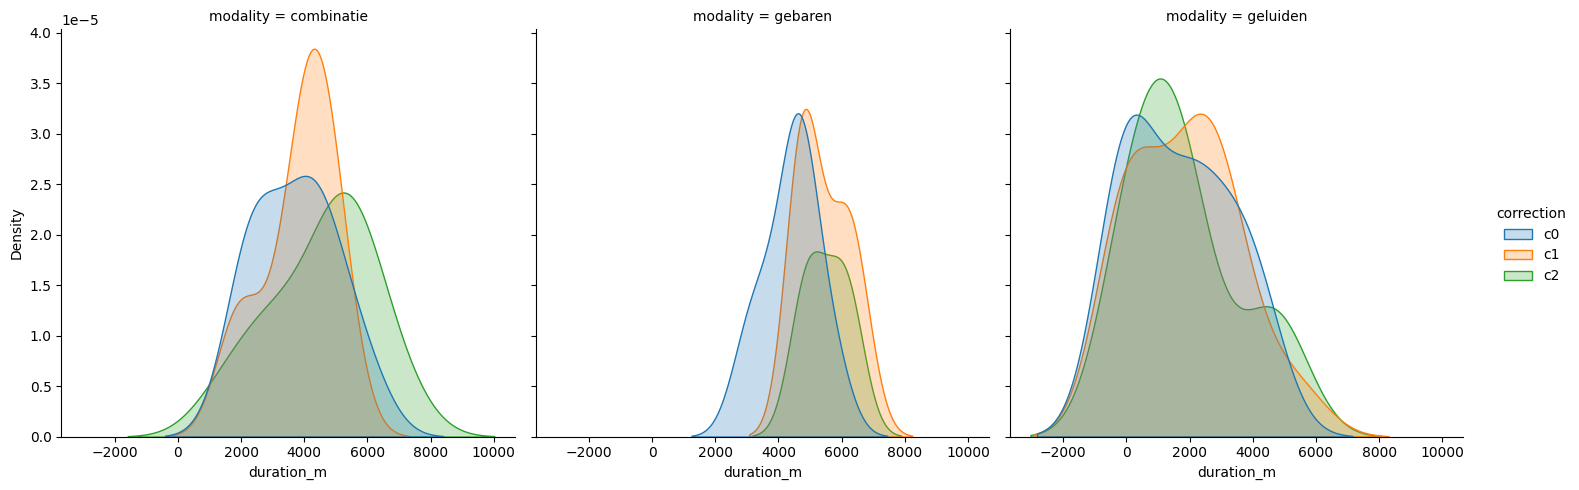

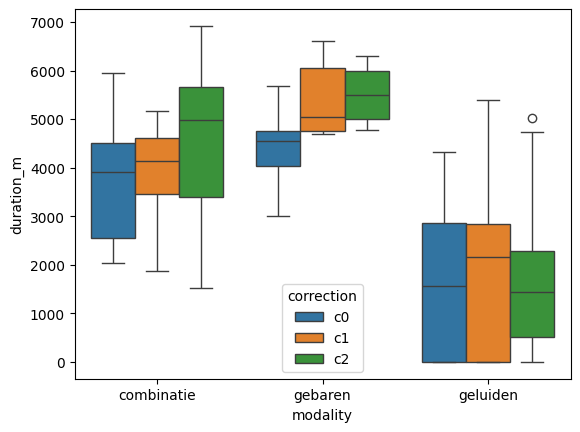

In [262]:
### plotting duration as distribution
sns.displot(subfeat_c, x="duration_m", col='modality', hue="correction", kind="kde", fill=True)
plt.show()

### plotting duration as boxplots
sns.boxplot(data=subfeat_c, x="modality", y="duration_m", hue="correction")
plt.show()


## Number of submovements

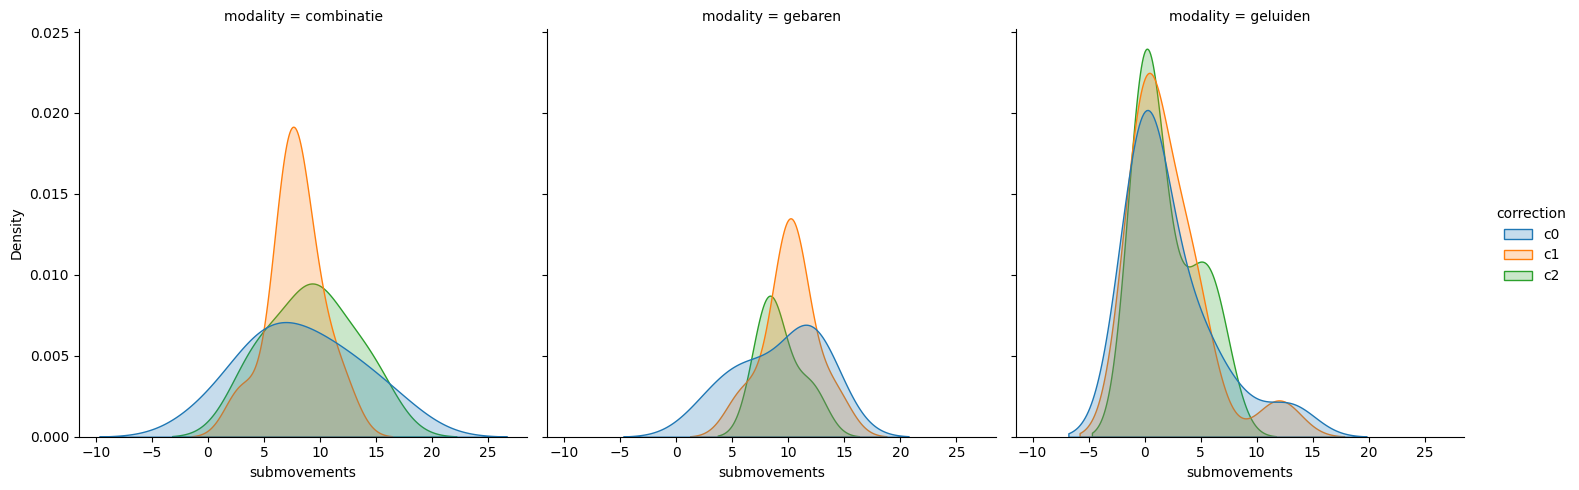

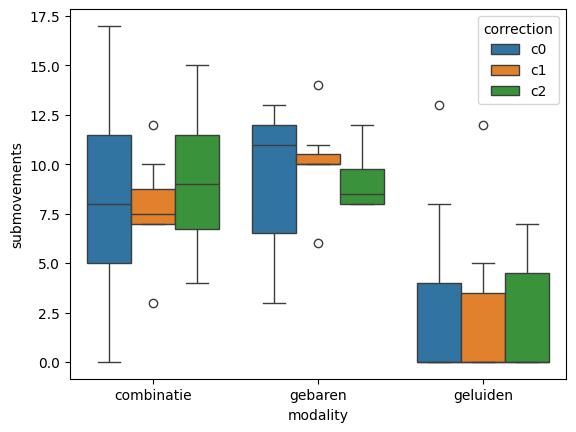

In [211]:
### plotting dist
sns.displot(subfeat_c, x="submovements", col='modality', hue="correction", kind="kde", fill=True)
plt.show()

### plotting boxplots
sns.boxplot(data=subfeat_c, x="modality", y="submovements", hue="correction")
plt.show()



## Intermittency

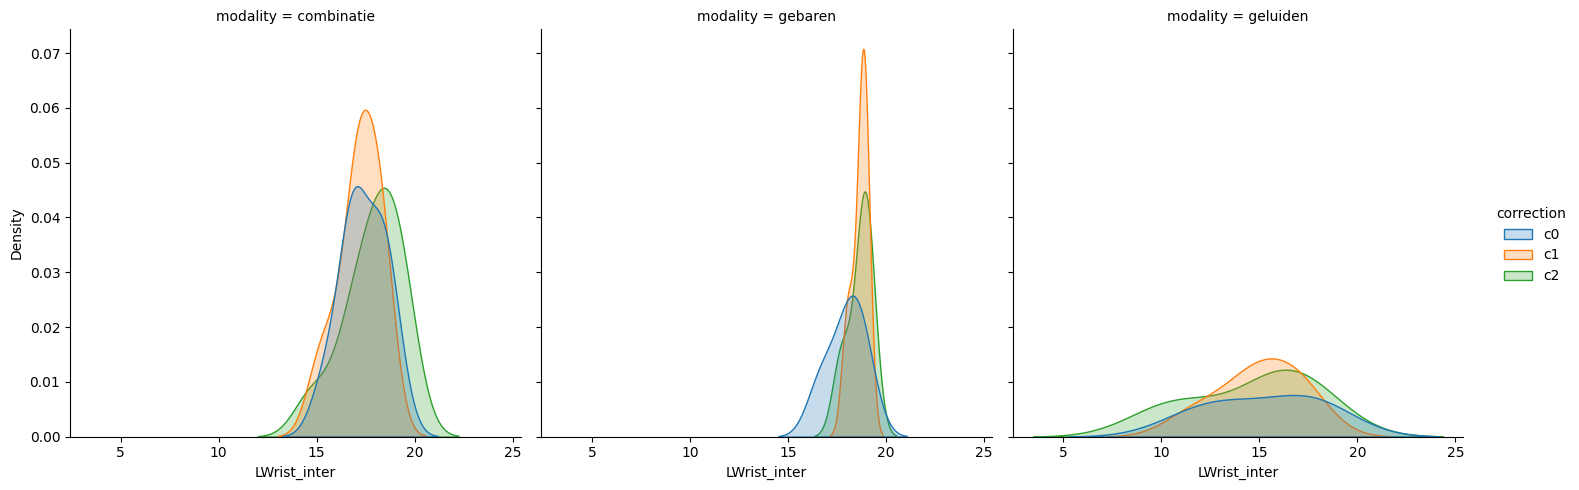

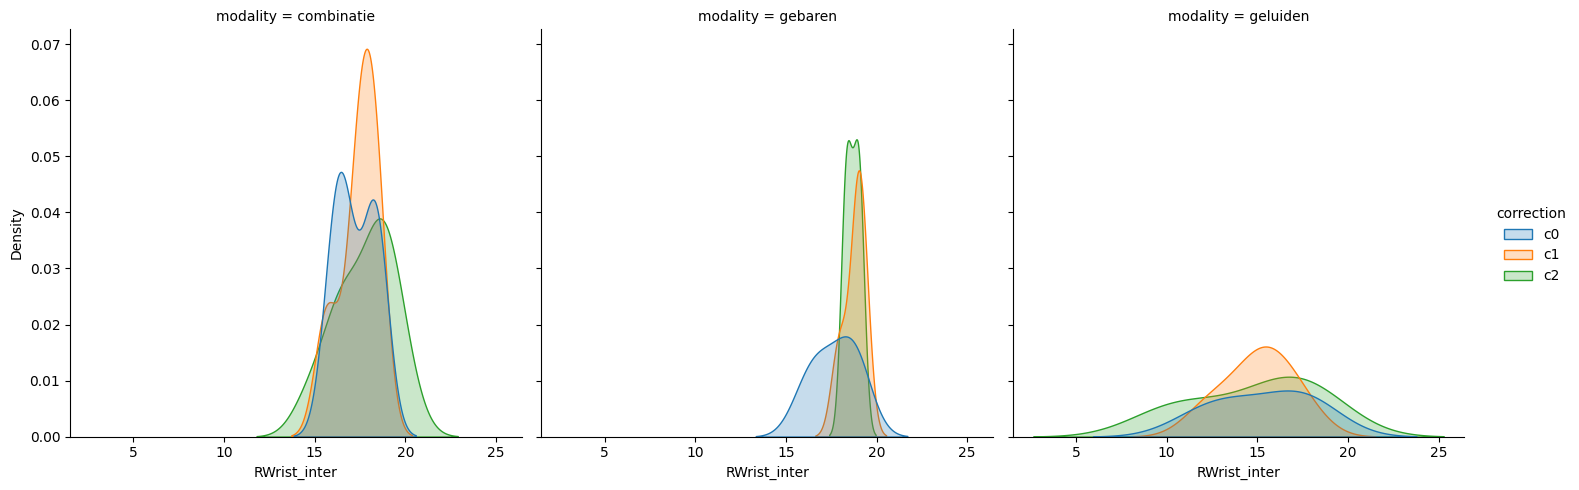

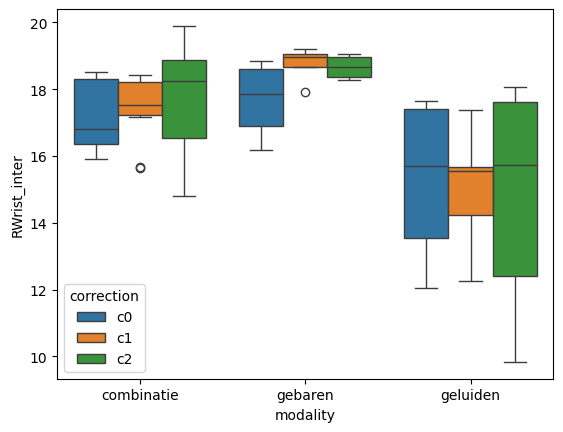

In [274]:
# plot dist
sns.displot(subfeat3, x="LWrist_inter", col='modality', hue="correction", kind="kde", fill=True)
sns.displot(subfeat3, x="RWrist_inter", col='modality', hue="correction", kind="kde", fill=True)
plt.show()

# plot boxplots
sns.boxplot(data=subfeat3, x="modality", y="RWrist_inter", hue="correction")
plt.show()

## Number of articulators

C:\Users\kadava\AppData\Local\Temp\ipykernel_15808\1548340547.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(subfeat_c, x="numArtic", col='modality', hue="correction", kind="kde", fill=True)


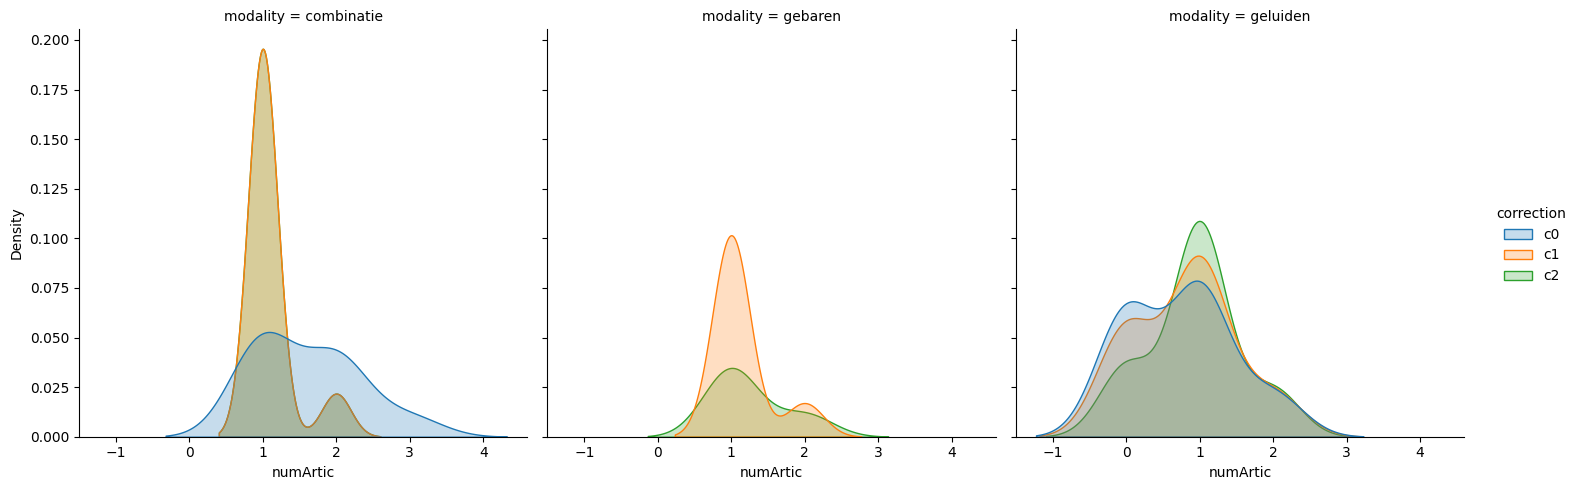

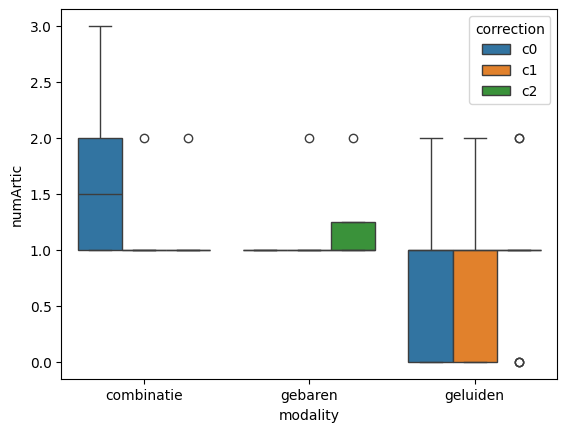

In [215]:
## plot dist
sns.displot(subfeat_c, x="numArtic", col='modality', hue="correction", kind="kde", fill=True)
plt.show()

## plot boxplots
sns.boxplot(data=subfeat_c, x="modality", y="numArtic", hue="correction")
plt.show()

## Duration of vocalization

C:\Users\kadava\AppData\Local\Temp\ipykernel_15808\1725610730.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(subfeat_c, x="duration_v", col='modality', hue="correction", kind="kde", fill=True)


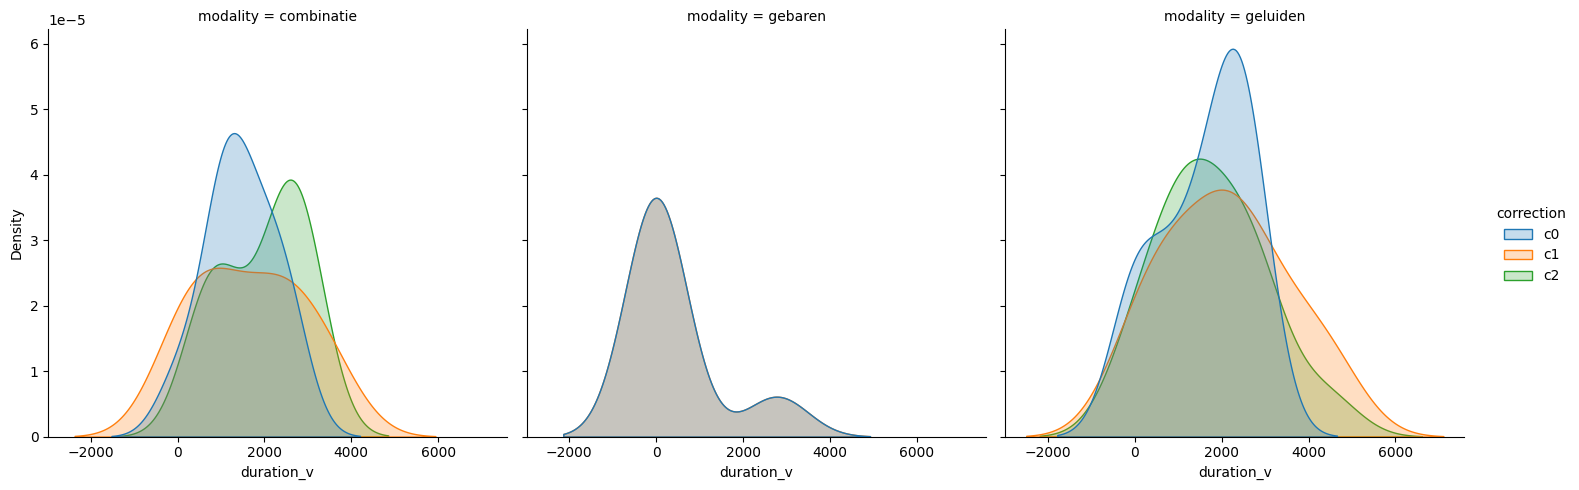

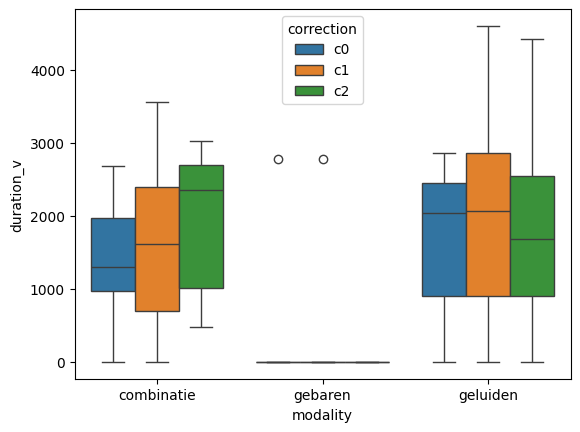

In [217]:
### plotting vocalization duration
sns.displot(subfeat_c, x="duration_v", col='modality', hue="correction", kind="kde", fill=True)
plt.show()

### plotting vocalization duration as boxplots
sns.boxplot(data=subfeat_c, x="modality", y="duration_v", hue="correction")
plt.show()

So it seems that in the unimodal conditions, the corrections (at least as long as difference between c0 and c1 is concerned) are longer in duration. This does not apply for multimodal condition

## Peaks in COP

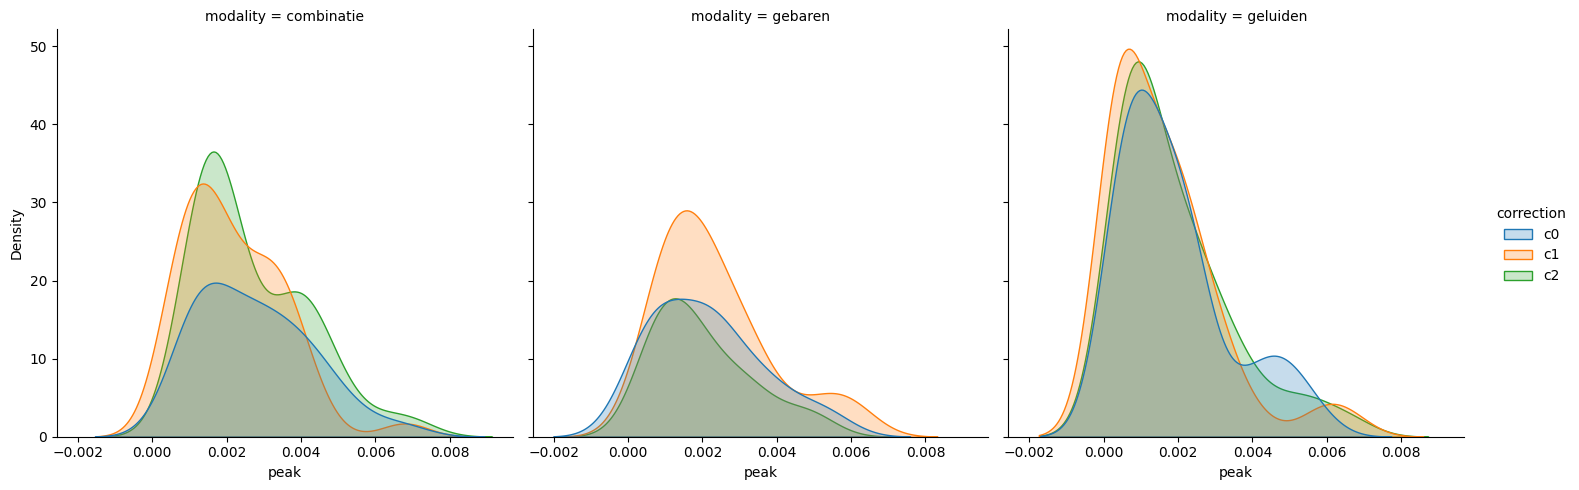

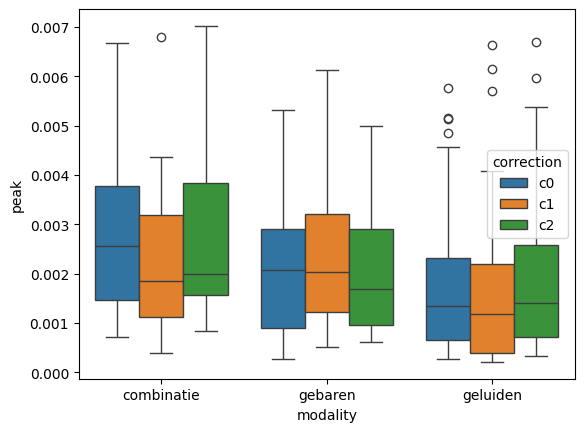

In [300]:
### plotting peaks in COPc

flat_data = []

for _, row in subfeat_c.iterrows():
    for peak in row['cop_peaks']:
        flat_data.append({"TrialID": row["TrialID"], "concept": row["concept"], "modality": row["modality"], "correction": row["correction"], "peak": peak})

flat_df = pd.DataFrame(flat_data)
flat_df = detect_outliers(flat_df, "peak")

# plot 
sns.displot(flat_df, x="peak", col="modality", hue='correction', kind="kde", fill=True)
plt.show()

# plot boxplots
sns.boxplot(data=flat_df, x="modality", y="peak", hue="correction")
plt.show()


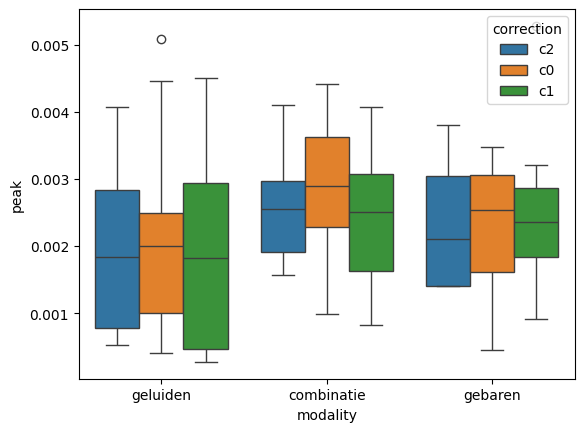

In [301]:
# get mean peak for each trial
mean_peaks = flat_df.groupby(["TrialID", "modality", "correction"])["peak"].mean().reset_index()

# plot mean peaks
sns.boxplot(data=mean_peaks, x="modality", y="peak", hue="correction")
plt.show()

Here in movement conditions (combinatie, gebaren), we see that there are high peaks in COP especially for the c0 trials.
But for mean peak this apply only for multimodal condition. In unimodal conditions, the peaks are higher in c1 trials.

## Peaks in amplitude envelope

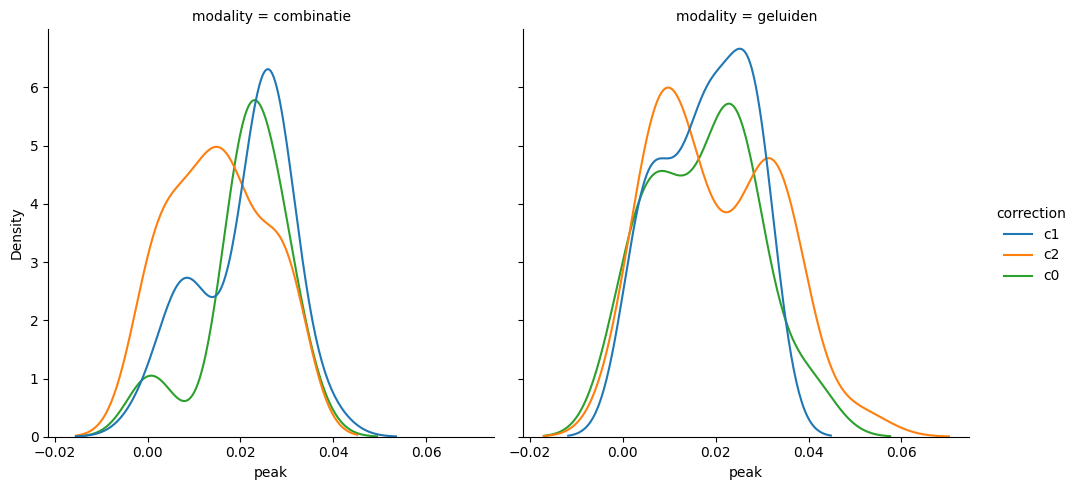

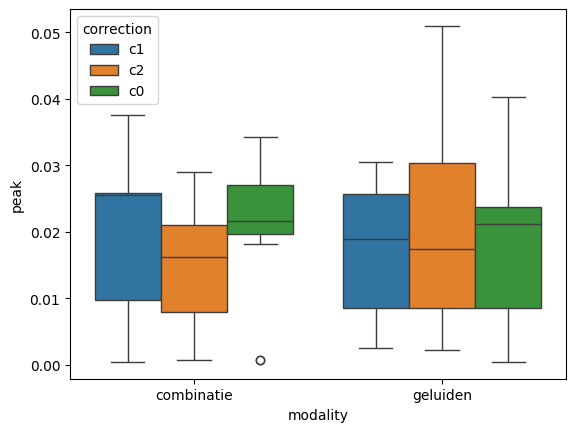

In [302]:
### plotting peaks in envelope

flat_data = []

for _, row in subfeat3.iterrows():
    for peak in row['env_peaks']:
        flat_data.append({"TrialID": row["TrialID"], "concept": row["concept"], "modality": row["modality"], "correction": row["correction"], "peak": peak})

flat_df = pd.DataFrame(flat_data)
flat_df = detect_outliers(flat_df, "peak")

# plot each modality separately in a grid, hue by correction
sns.displot(flat_df, x="peak", col="modality", hue="correction", kind="kde")
plt.show()

                  
# plot boxplots
sns.boxplot(data=flat_df, x="modality", y="peak", hue="correction")
plt.show()

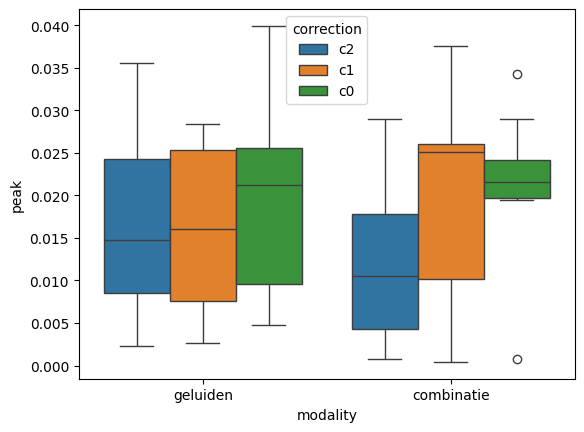

In [303]:
# mean peaks
mean_peaks = flat_df.groupby(["TrialID", "modality", "correction"])["peak"].mean().reset_index()

# plot mean peaks
sns.boxplot(data=mean_peaks, x="modality", y="peak", hue="correction")
plt.show()



## Peaks in elbow acc

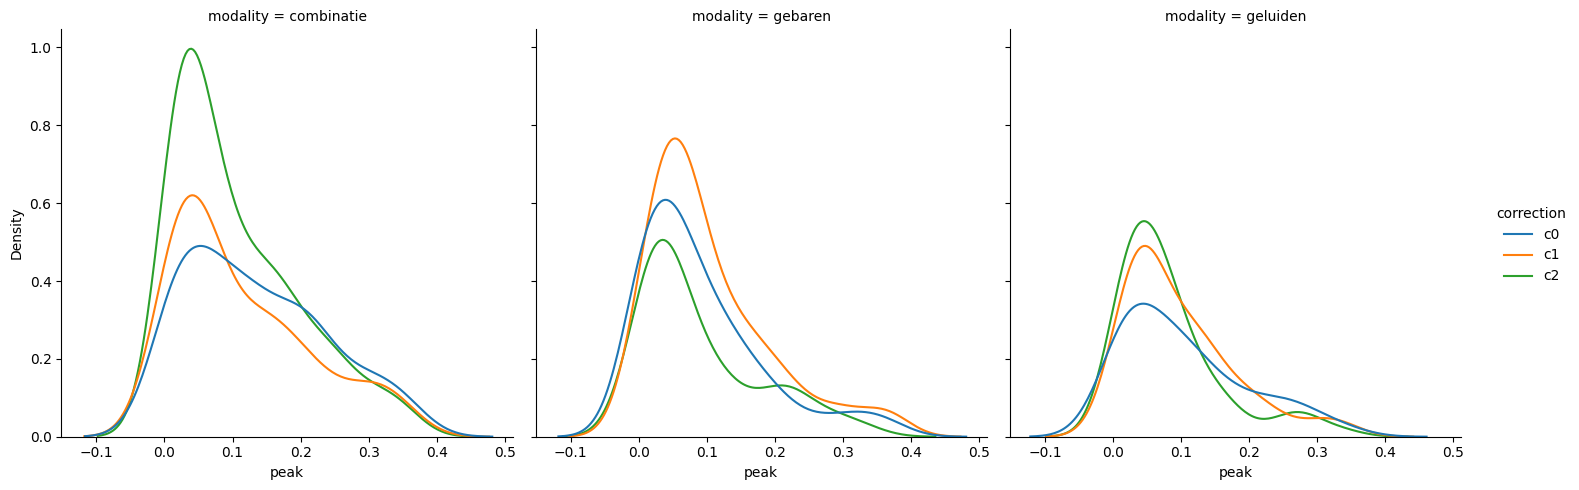

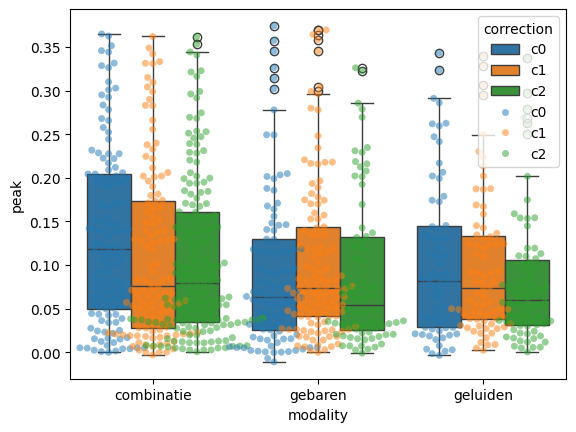

In [304]:
# plot columns that contain elbow and acc
flat_data = []

for _, row in subfeat_c.iterrows():
    for col in row.index:
        if "elbow" in col and "acc" in col and 'peaks' in col:
            # check if there are any peaks
            if row[col] != [] or row[col] != [np.nan]: 
                for peak in row[col]:
                    flat_data.append({"TrialID": row["TrialID"], "concept": row["concept"], "modality": row["modality"], "correction": row["correction"], "peak": peak, 'concept_id': row['concept_id']})

flat_df = pd.DataFrame(flat_data)
flat_df = detect_outliers(flat_df, "peak")

# plot each modality separately in a grid, hue by correction
sns.displot(flat_df, x="peak", col="modality", hue="correction", kind="kde")
plt.show()

# plot as boxplot
sns.boxplot(data=flat_df, x="modality", y="peak", hue="correction")
# connect individual points belonging to same concept_id
sns.swarmplot(data=flat_df, x="modality", y="peak", hue="correction", dodge=True, alpha=0.5)
plt.show()


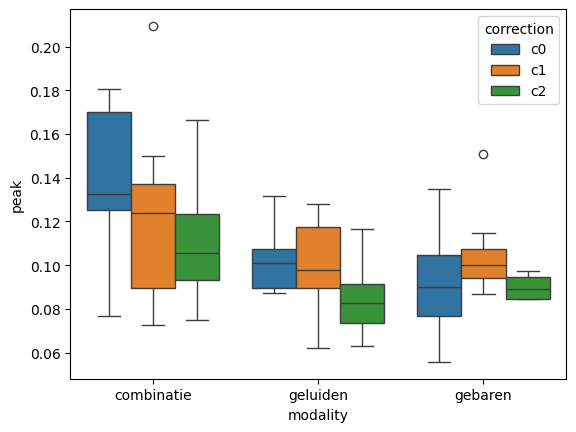

In [305]:
# mean peaks

mean_peaks = flat_df.groupby(["TrialID", "modality", "correction"])["peak"].mean().reset_index()

# plot mean peaks
sns.boxplot(data=mean_peaks, x="modality", y="peak", hue="correction")
plt.show()

## Peaks in elbow speed

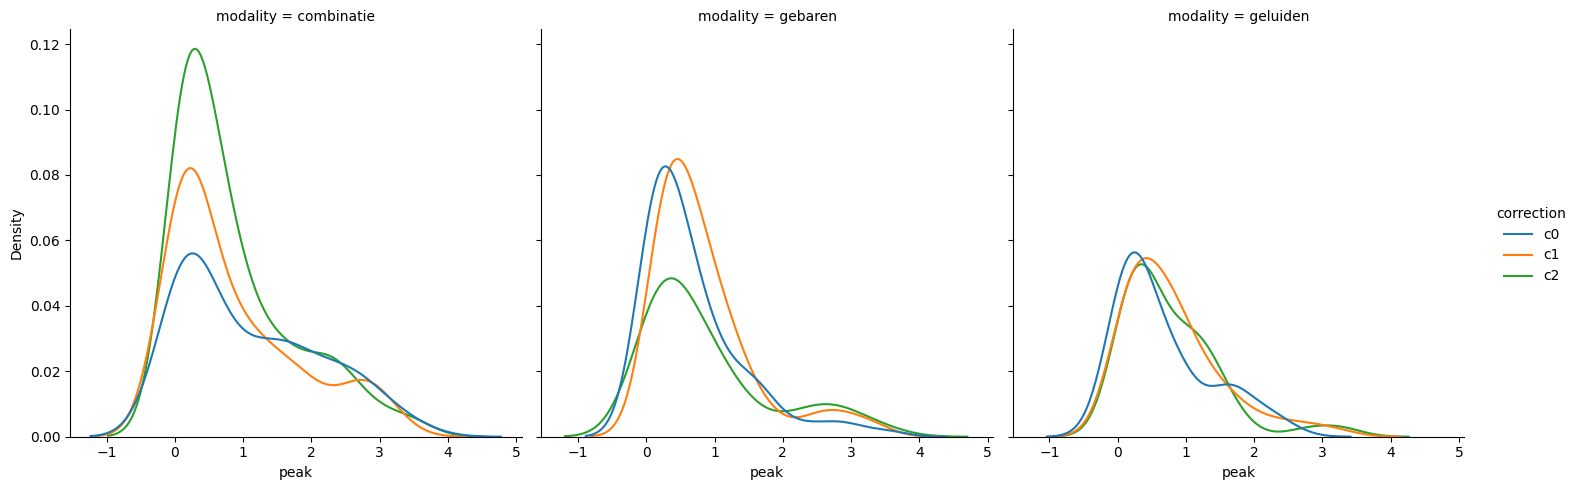

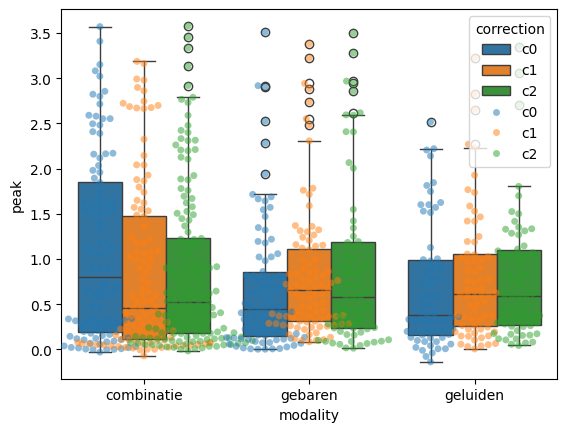

In [306]:
flat_data = []

for _, row in subfeat_c.iterrows():
    for col in row.index:
        if "elbow" in col and "speed" in col and 'peaks' in col:
            for peak in row[col]:
                flat_data.append({"TrialID": row["TrialID"], "concept": row["concept"], "modality": row["modality"], "correction": row["correction"], "peak": peak})

flat_df = pd.DataFrame(flat_data)

# outliers
flat_df = detect_outliers(flat_df, "peak")

# plot each modality separately in a grid, hue by correction
sns.displot(flat_df, x="peak", col="modality", hue="correction", kind="kde")
plt.show()

# plot as boxplot
sns.boxplot(data=flat_df, x="modality", y="peak", hue="correction")
sns.swarmplot(data=flat_df, x="modality", y="peak", hue="correction", dodge=True, alpha=0.5)
plt.show()

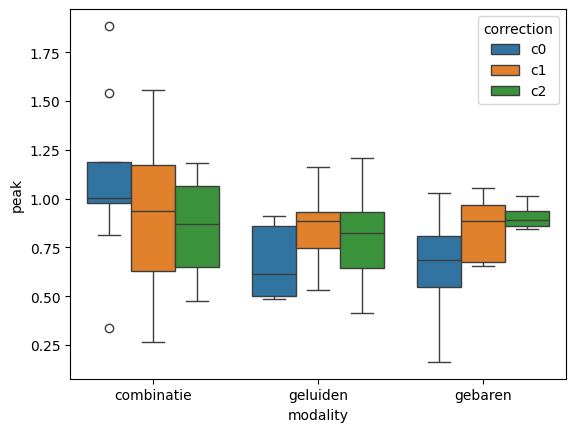

In [307]:
# mean peaks

mean_peaks = flat_df.groupby(["TrialID", "modality", "correction"])["peak"].mean().reset_index()

# plot mean peaks
sns.boxplot(data=mean_peaks, x="modality", y="peak", hue="correction")
plt.show()

## Peaks in elbow moment

Note that we still have to find a way how to sum all moments of a joint

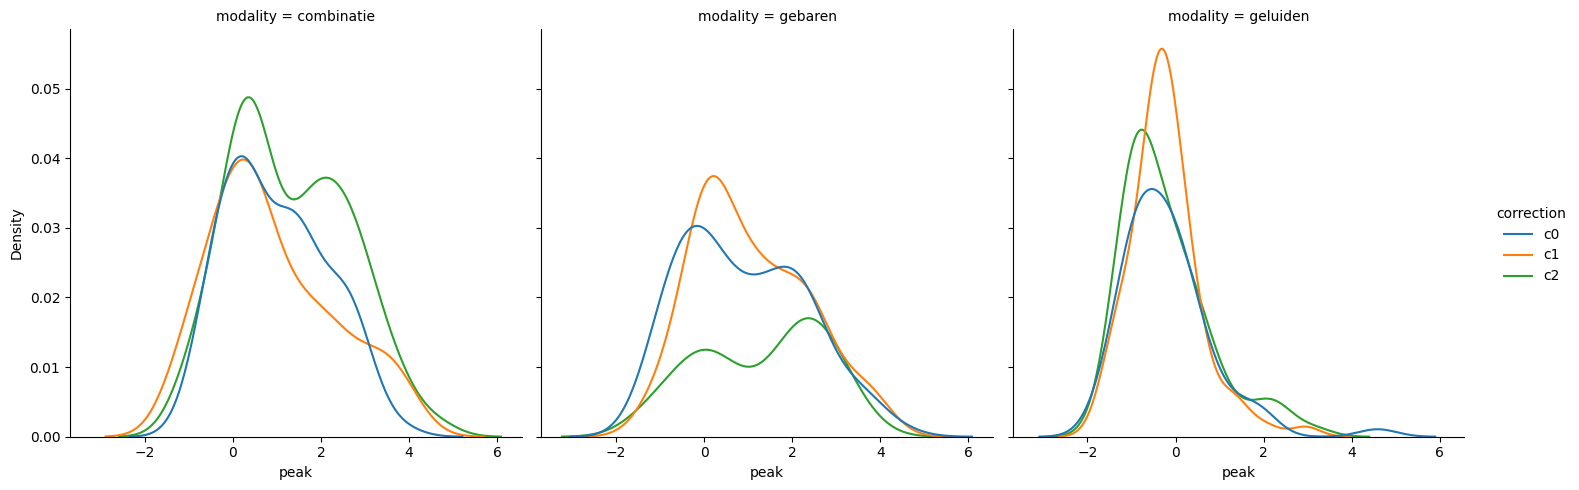

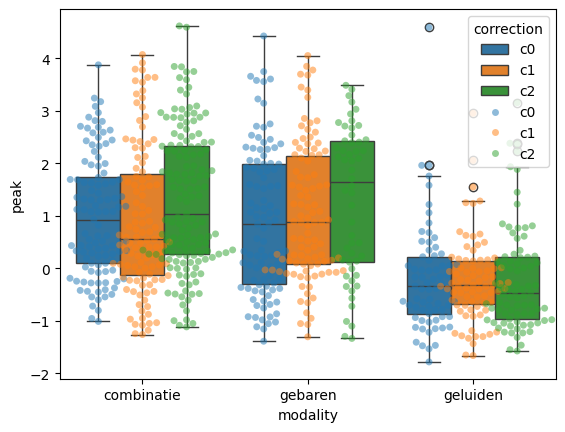

In [308]:
flat_data = []

for _, row in subfeat_c.iterrows():
    for col in row.index:
        if "elbow" in col and "moment" in col and 'peaks' in col:
            for peak in row[col]:
                flat_data.append({"TrialID": row["TrialID"], "concept": row["concept"], "modality": row["modality"], "correction": row["correction"], "peak": peak})

flat_df = pd.DataFrame(flat_data)
flat_df = detect_outliers(flat_df, "peak")

# plot each modality separately in a grid, hue by correction
sns.displot(flat_df, x="peak", col="modality", hue="correction", kind="kde")
plt.show()

# plot as boxplot
sns.boxplot(data=flat_df, x="modality", y="peak", hue="correction")
# swarmplot
sns.swarmplot(data=flat_df, x="modality", y="peak", hue="correction", dodge=True, alpha=0.5)
plt.show()

## Peaks in wrist acc

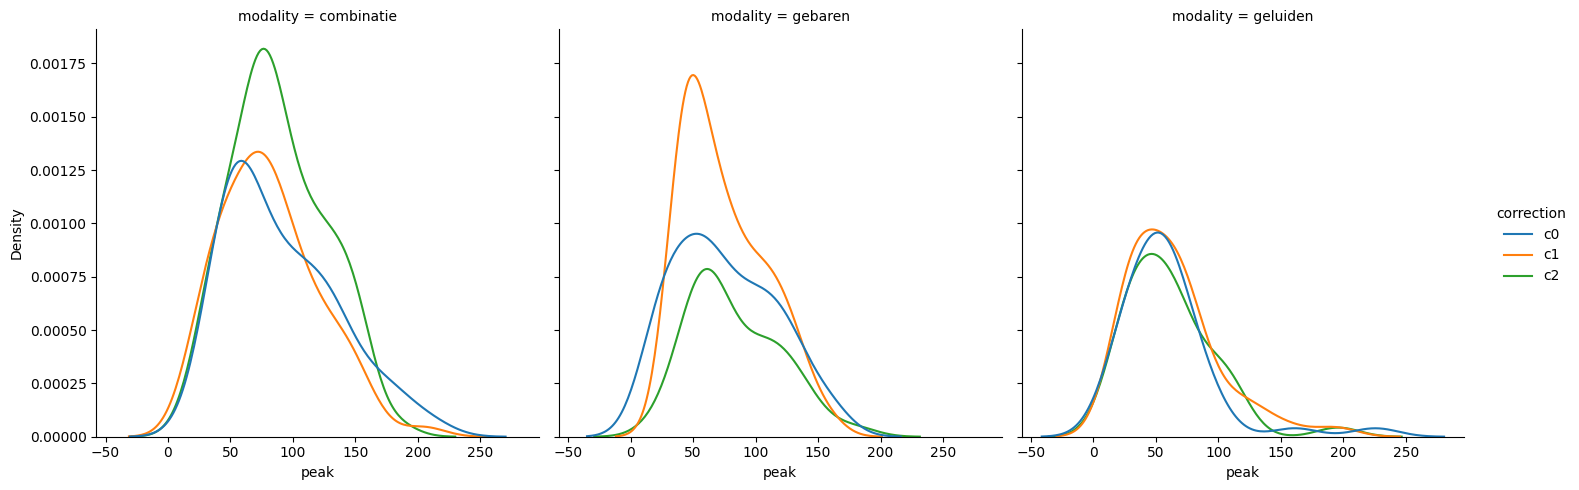

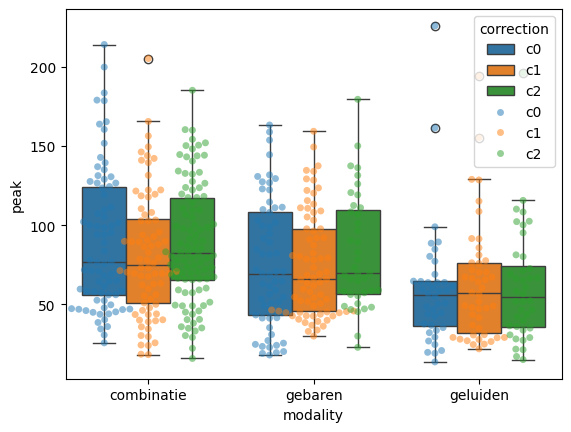

In [231]:
flat_data = []

for _, row in subfeat_c.iterrows():
    for col in row.index:
        if "Wrist" in col and 'peaks' in col:
            for peak in row[col]:
                flat_data.append({"TrialID": row["TrialID"], "concept": row["concept"], "modality": row["modality"], "correction": row["correction"], "peak": peak})

flat_df = pd.DataFrame(flat_data)

# plot dist
sns.displot(flat_df, x="peak", col="modality", hue="correction", kind="kde")
plt.show()

# plot as boxplot
sns.boxplot(data=flat_df, x="modality", y="peak", hue="correction")
sns.swarmplot(data=flat_df, x="modality", y="peak", hue="correction", dodge=True, alpha=0.5)
plt.show()


## Peaks in arm speed

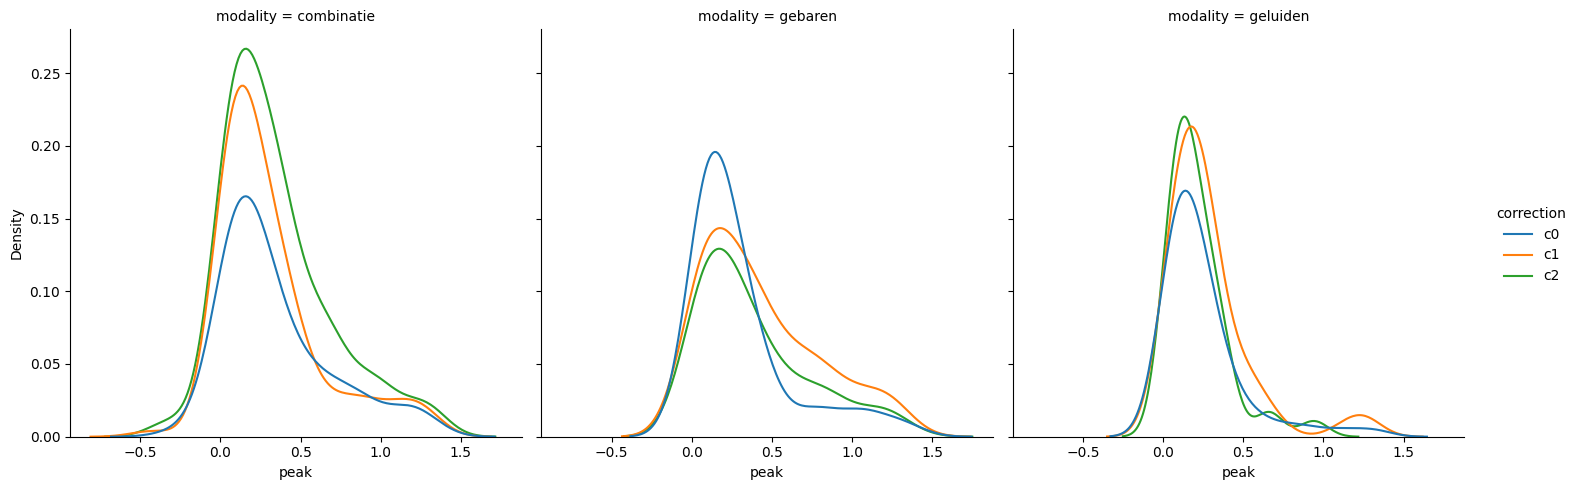

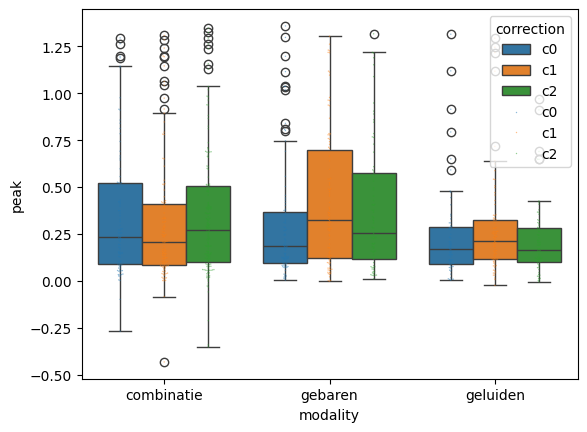

In [310]:
flat_data = []

for _, row in subfeat_c.iterrows():
    for col in row.index:
        if "arm" in col and 'speed' in col and 'peaks' in col and 'add' in col:
            for peak in row[col]:
                flat_data.append({"TrialID": row["TrialID"], "concept": row["concept"], "modality": row["modality"], "correction": row["correction"], "peak": peak})

flat_df = pd.DataFrame(flat_data)
flat_df = detect_outliers(flat_df, "peak")

# plot dist
sns.displot(flat_df, x="peak", col="modality", hue="correction", kind="kde")
plt.show()

# plot as boxplot
sns.boxplot(data=flat_df, x="modality", y="peak", hue="correction")
sns.swarmplot(data=flat_df, x="modality", y="peak", hue="correction", dodge=True, alpha=0.5, size=1)
plt.show()

## Peaks in arm acceleration

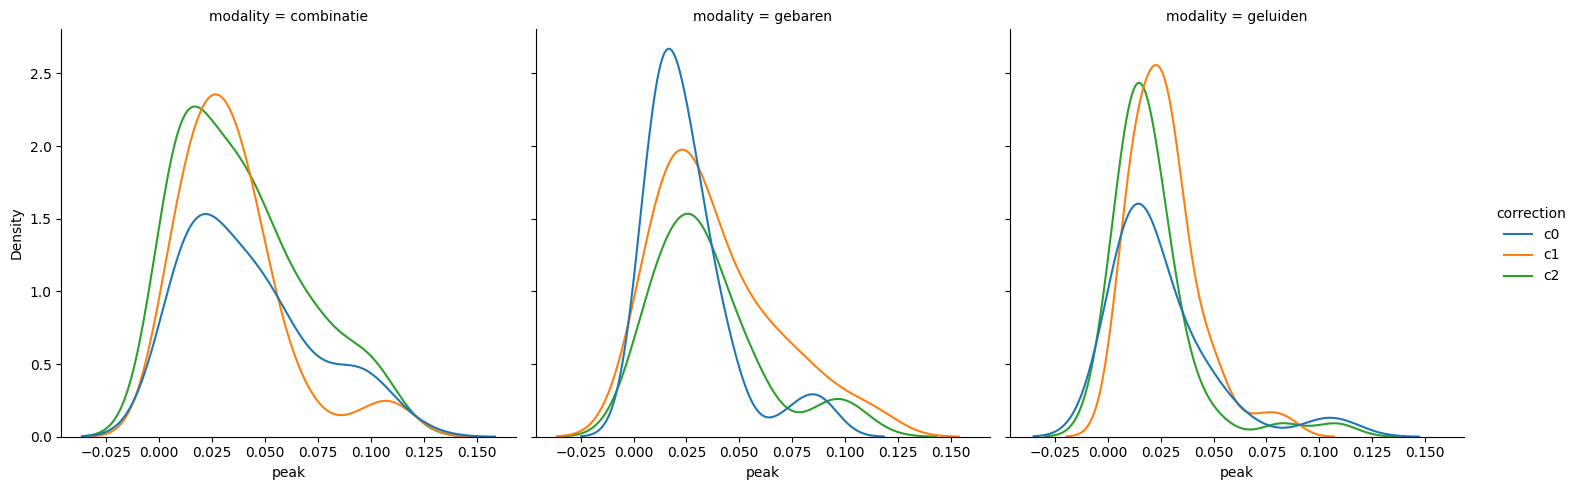

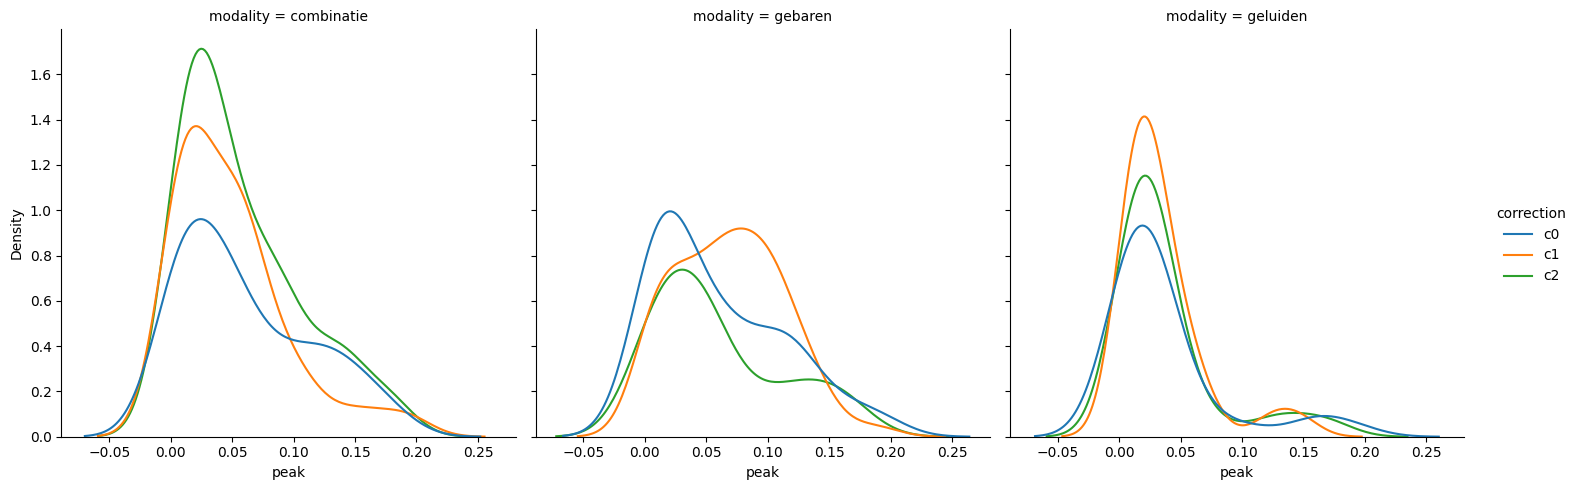

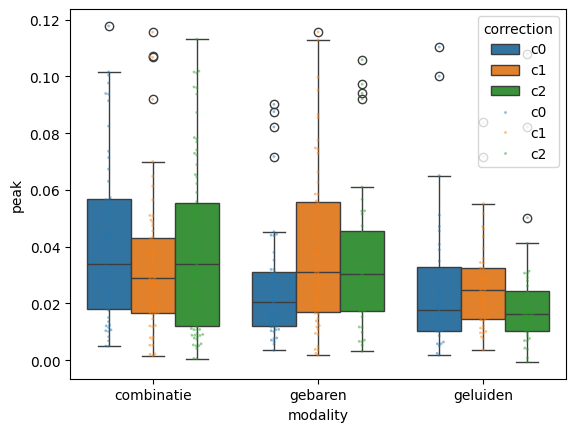

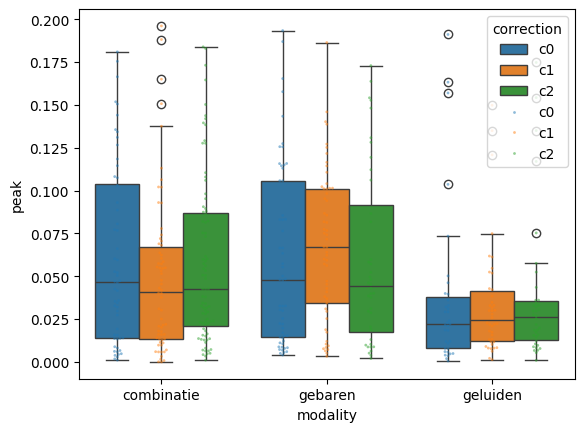

In [312]:
flat_data_r = []
flat_data_l = []

for _, row in subfeat_c.iterrows():
    for col in row.index:
        if "arm" in col and 'acc' in col and 'peaks' in col and 'add' in col and '_l_' in col:
            for peak in row[col]:
                flat_data_r.append({"TrialID": row["TrialID"], "concept": row["concept"], "modality": row["modality"], "correction": row["correction"], "peak": peak})
        elif "arm" in col and 'acc' in col and 'peaks' in col and 'add' in col and '_r_' in col:
            for peak in row[col]:
                flat_data_l.append({"TrialID": row["TrialID"], "concept": row["concept"], "modality": row["modality"], "correction": row["correction"], "peak": peak})

flat_df_r = pd.DataFrame(flat_data_r)
flat_df_l = pd.DataFrame(flat_data_l)

# get rid of outliers based on Tukey's fences
flat_df_r = detect_outliers(pd.DataFrame(flat_df_r), "peak")
flat_df_l = detect_outliers(pd.DataFrame(flat_df_l), "peak")

# plot dist
sns.displot(flat_df_r, x="peak", col="modality", hue="correction", kind="kde")
plt.show()

sns.displot(flat_df_l, x="peak", col="modality", hue="correction", kind="kde")
plt.show()

# plot as boxplot
sns.boxplot(data=flat_df_r, x="modality", y="peak", hue="correction")
sns.swarmplot(data=flat_df_r, x="modality", y="peak", hue="correction", dodge=True, alpha=0.5, size=2)
plt.show()

sns.boxplot(data=flat_df_l, x="modality", y="peak", hue="correction")
sns.swarmplot(data=flat_df_l, x="modality", y="peak", hue="correction", dodge=True, alpha=0.5, size=2)
plt.show()



## peaks in arm acc

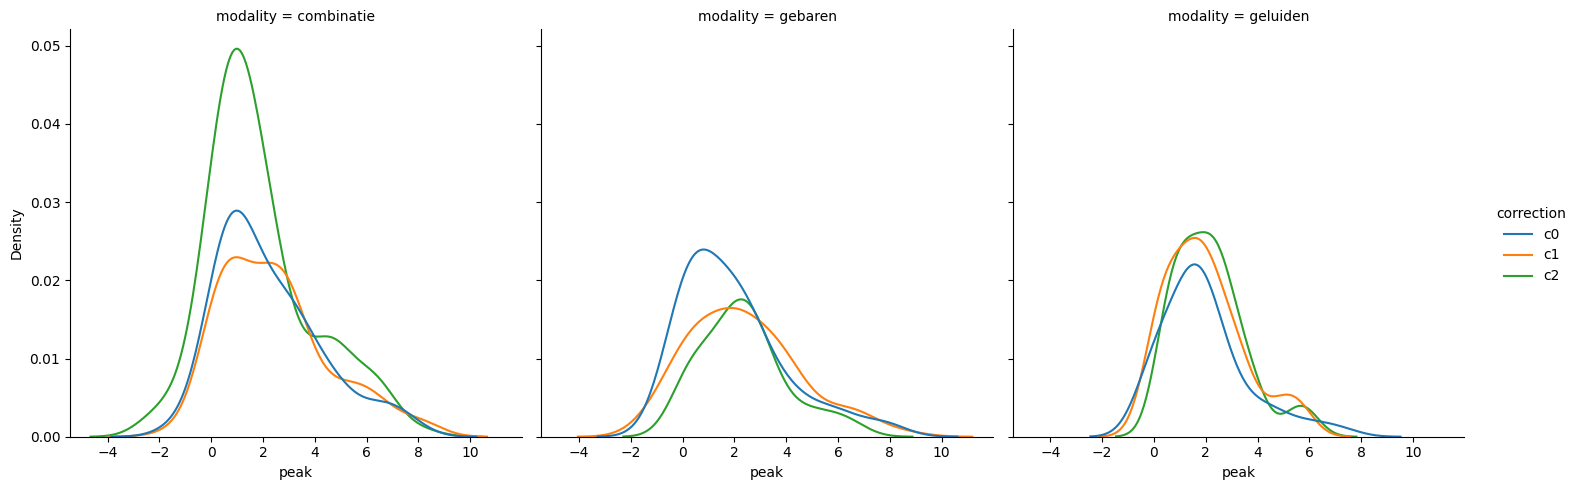

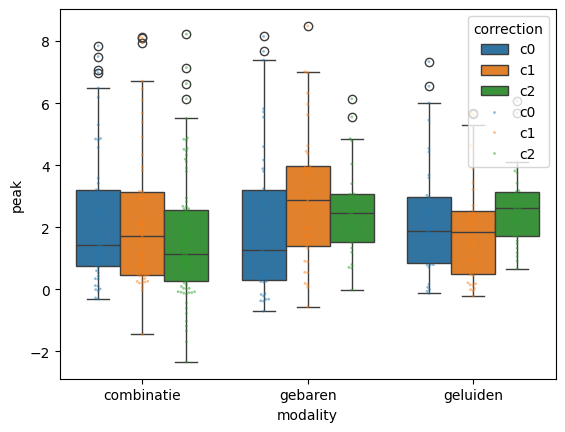

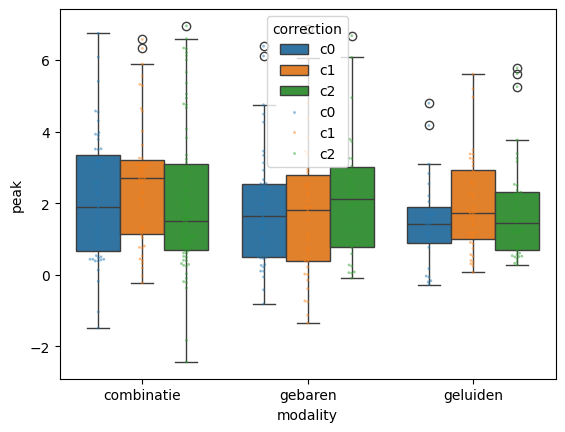

In [313]:
flat_data_l = []
flat_data_r = []    

for _, row in subfeat_c.iterrows():
    for col in row.index:
        if "arm" in col and 'moment' in col and 'peaks' in col and 'add' in col and '_l_' in col:
            for peak in row[col]:
                flat_data_l.append({"TrialID": row["TrialID"], "concept": row["concept"], "modality": row["modality"], "correction": row["correction"], "peak": peak})
        elif "arm" in col and 'moment' in col and 'peaks' in col and 'add' in col and '_r_' in col:
            for peak in row[col]:
                flat_data_r.append({"TrialID": row["TrialID"], "concept": row["concept"], "modality": row["modality"], "correction": row["correction"], "peak": peak})

flat_df_r = pd.DataFrame(flat_data_r)
flat_df_l = pd.DataFrame(flat_data_l)


# get rid of outliers based on Tukey's fences
flat_df_r = detect_outliers(pd.DataFrame(flat_df_r), "peak")
flat_df_l = detect_outliers(pd.DataFrame(flat_df_l), "peak")

# merge the two dataframes
flat_df = pd.concat([flat_df_r, flat_df_l], ignore_index=True)

# plot dist
sns.displot(flat_df, x="peak", col="modality", hue="correction", kind="kde")
plt.show()


# plot as boxplot
sns.boxplot(data=flat_df_r, x="modality", y="peak", hue="correction")
sns.swarmplot(data=flat_df_r, x="modality", y="peak", hue="correction", dodge=True, alpha=0.5, size=2)
plt.show()

sns.boxplot(data=flat_df_l, x="modality", y="peak", hue="correction")
sns.swarmplot(data=flat_df_l, x="modality", y="peak", hue="correction", dodge=True, alpha=0.5, size=2)
plt.show()

TODO / to think

- we still need to find a way to sum all moments of a joint
- should we z-scale the timeseries since we compare different people?
- is peak magnitude the best way to compare?
